This notebook will be mainly used for the capstone project

# Assignment for Week 3 :
## Segmenting and Clustering Neighborhoods in Toronto
### Question 1

### 1/ Install all the libraries

In [ ]:
! pip install beautifulsoup4
! pip install lxml
! pip install html5lib
! pip install requests

### 2/ Import libraries

In [2]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd

### 3/ Web Scraping

First, **get the HTML code** of the website using BeautifulSoup

In [5]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text
soup = BeautifulSoup (source,"lxml")
#print(soup.prettify())

Then, get the HTML code of the table, use pandas to read it as a dataframe.

In [6]:
table = soup.find_all('table')[0]
df = pd.read_html(str(table))[0]
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


**Data cleaning**:
+ Drop cells with a borough that is Not assigned.
+ Combine two rows with same post code into one row with the neighborhoods separated with a comma.
+ If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. 

In [7]:
df = df[df['Borough']!='Not assigned']
df.reset_index(inplace=True, drop = True)

for i in df.index:
    if df.iloc[i]['Neighbourhood']=='Not assigned':
        df.iloc[i]['Neighbourhood']=df.iloc[i]['Borough']

df = df.groupby(['Postcode','Borough']).agg(lambda col:','.join(col))
df.reset_index(inplace = True)
df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
df.shape

(103, 3)

### Question 2

In [ ]:
!pip install geocoder

Open the Geospatial coordinates data as dataframe by pandas

In [10]:
import geocoder
path = 'http://cocl.us/Geospatial_data'
df_geo = pd.read_csv(path)
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge the two dataframes.

In [11]:
df_ll = pd.merge(df,df_geo,how = 'left', left_on="Postcode",right_on='Postal Code').drop('Postal Code',axis=1)
df_ll.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Question 3

In [ ]:
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes

In [12]:
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium

print('Libraries imported.')

Libraries imported.


#### Use geopy library to get the latitude and longitude values of  Toronto

In [13]:
address = 'Toronto, Ontario'

geolocator = Nominatim (user_agent="Lola_Toronto_explore")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


**Create a map of Toronto with neighborhoods superimposed on top.**

In [14]:
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(df_ll['Latitude'], df_ll['Longitude'], df_ll['Borough'], df_ll['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

**Utilizing the Foursquare API to explore the neighborhoods and segment them**
First, define Foursquare Credentials and Version

In [17]:
#@hidden_cell
CLIENT_ID = 'FVISL4XZWUPZ4KAH3DKXVELZYEMGNC0AVR55QV1XVICMSBST' # your Foursquare ID
CLIENT_SECRET = 'IT1PJDNXRKKQKL3CHMUVYDZDK0W5VJY3XZ1MLSVYGGCDRCMR' # your Foursquare Secret
VERSION = '20190929'

Create a function to get the **top 100 venues** that are in all the neighborhoods in the Focus_borough within a **radius of 500 meters**. 

In [18]:
def getNearbyVenues(boroughs, names, latitudes, longitudes, radius=500, LIMIT = 100):
    
    venues_list=[]
    for borough, name, lat, lng in zip(boroughs, names, latitudes, longitudes):            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [42]:
all_venues = getNearbyVenues(boroughs=df_ll['Borough'],
                               names=df_ll['Neighbourhood'],
                               latitudes=df_ll['Latitude'],
                               longitudes=df_ll['Longitude']
                              )
all_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Scarborough,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


### Analyze Each Neighborhood
#### First, using "one hot encoding" to show all the categories data for each neighborhood.

In [43]:
Toronto_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")
fixed_columns = ['Borough','Neighborhoods']+list(Toronto_onehot.columns)
# add neighborhood column back to dataframe
Toronto_onehot['Neighborhoods'] = all_venues ['Neighborhood'] 
Toronto_onehot['Borough'] = all_venues ['Borough'] 
Toronto_onehot = Toronto_onehot[fixed_columns]
Toronto_onehot.head()

,Borough,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Scarborough,"Rouge,Malvern",0,0,0,0,0,0,0,

#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [44]:
Toronto_grouped = Toronto_onehot.groupby(['Borough','Neighborhoods']).mean().reset_index()
print(Toronto_grouped.shape)
Toronto_grouped.head()

(100, 275)


,Borough,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Central Toronto,Davisville,0.0,0.0,0.0,0.0

#### Print each neighborhood along with the top 5 most common venues

In [45]:
num_top_venues = 10

for hood in Toronto_grouped ['Neighborhoods']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhoods'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Davisville----
                venue  freq
0      Sandwich Place  0.09
1        Dessert Shop  0.09
2         Coffee Shop  0.06
3                 Gym  0.06
4                Café  0.06
5  Italian Restaurant  0.06
6         Pizza Place  0.06
7    Sushi Restaurant  0.06
8          Restaurant  0.03
9               Diner  0.03


----Davisville North----
                       venue  freq
0             Breakfast Spot  0.14
1                        Gym  0.14
2             Sandwich Place  0.14
3             Clothing Store  0.14
4                      Hotel  0.14
5          Food & Drink Shop  0.14
6                       Park  0.14
7         Mexican Restaurant  0.00
8              Metro Station  0.00
9  Middle Eastern Restaurant  0.00


----Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West----
                 venue  freq
0          Coffee Shop  0.13
1                  Pub  0.13
2           Restaurant  0.07
3         Liquor Store  0.07
4          Supermarket  0.07
5           Bag

                       venue  freq
0             Clothing Store  0.08
1                Coffee Shop  0.08
2             Cosmetics Shop  0.03
3                       Café  0.03
4  Middle Eastern Restaurant  0.03
5        Japanese Restaurant  0.02
6                  Bookstore  0.02
7                      Diner  0.02
8                      Plaza  0.02
9                Pizza Place  0.02


----St. James Town----
                venue  freq
0         Coffee Shop  0.07
1                Café  0.06
2               Hotel  0.05
3          Restaurant  0.05
4  Italian Restaurant  0.04
5            Beer Bar  0.03
6      Cosmetics Shop  0.03
7              Bakery  0.03
8      Clothing Store  0.03
9      Breakfast Spot  0.03


----Stn A PO Boxes 25 The Esplanade----
                venue  freq
0         Coffee Shop  0.11
1  Italian Restaurant  0.04
2          Restaurant  0.04
3                Café  0.04
4        Cocktail Bar  0.03
5  Seafood Restaurant  0.03
6            Beer Bar  0.03
7               

                             venue  freq
0                             Park   0.5
1                            River   0.5
2                Accessories Store   0.0
3               Miscellaneous Shop   0.0
4                            Motel   0.0
5              Monument / Landmark   0.0
6  Molecular Gastronomy Restaurant   0.0
7       Modern European Restaurant   0.0
8                Mobile Phone Shop   0.0
9        Middle Eastern Restaurant   0.0


----Westmount----
                        venue  freq
0                 Pizza Place  0.25
1              Discount Store  0.12
2          Chinese Restaurant  0.12
3                Intersection  0.12
4              Sandwich Place  0.12
5                 Coffee Shop  0.12
6   Middle Eastern Restaurant  0.12
7          Miscellaneous Shop  0.00
8           Mobile Phone Shop  0.00
9  Modern European Restaurant  0.00


----Canada Post Gateway Processing Centre----
                        venue  freq
0                       Hotel  0.18
1            

                       venue  freq
0           Ramen Restaurant  0.08
1                Coffee Shop  0.08
2                 Restaurant  0.06
3                Pizza Place  0.06
4                       Café  0.06
5             Sandwich Place  0.06
6        Japanese Restaurant  0.06
7           Sushi Restaurant  0.06
8                      Plaza  0.03
9  Middle Eastern Restaurant  0.03


----Willowdale West----
            venue  freq
0        Pharmacy  0.14
1   Grocery Store  0.14
2         Butcher  0.14
3  Discount Store  0.14
4     Coffee Shop  0.14
5     Pizza Place  0.14
6    Home Service  0.14
7            Park  0.00
8          Museum  0.00
9     Men's Store  0.00


----York Mills West----
                             venue  freq
0                             Park   0.4
1                             Bank   0.2
2                Convenience Store   0.2
3                              Bar   0.2
4                Accessories Store   0.0
5                Mobile Phone Shop   0.0
6           

                venue  freq
0      Breakfast Spot  0.13
1           Gift Shop  0.13
2        Dessert Shop  0.07
3                 Bar  0.07
4                Bank  0.07
5             Dog Run  0.07
6       Movie Theater  0.07
7          Restaurant  0.07
8  Italian Restaurant  0.07
9         Coffee Shop  0.07


----Runnymede,Swansea----
                venue  freq
0                Café  0.08
1  Italian Restaurant  0.05
2    Sushi Restaurant  0.05
3         Pizza Place  0.05
4         Coffee Shop  0.05
5           Bookstore  0.03
6                 Pub  0.03
7   Electronics Store  0.03
8           Gastropub  0.03
9          Restaurant  0.03


----Caledonia-Fairbanks----
                             venue  freq
0                             Park   0.4
1                    Women's Store   0.2
2                           Market   0.2
3             Fast Food Restaurant   0.2
4                Accessories Store   0.0
5        Middle Eastern Restaurant   0.0
6              Monument / Landmark   0.

#### Create a function to sort the venues in descending order

In [46]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Create the new dataframe and display the top 10 venues for each neighborhood.

In [79]:
import numpy as np
num_top_venues = 25

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough','Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = Toronto_grouped['Neighborhoods']
neighborhoods_venues_sorted['Borough'] = Toronto_grouped['Borough']


for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Borough,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
0,Central Toronto,Davisville,Dessert Shop,Sandwich Place,Coffee Shop,Sushi Restaurant,Italian Restaurant,Pizza Place,Café,Gym,Brewery,Fried Chicken Joint,Pharmacy,Deli / Bodega,Diner,Greek Restaurant,Park,Costume Shop,Restaurant,Indian Restaurant,Thai Restaurant,Farmers Market,Seafood Restaurant,Toy / Game Store,Gourmet Shop,Doner Restaurant,Dog Run
1,Central Toronto,Davisville North,Park,Hotel,Sandwich Place,Food & Drink Shop,Clothing Store,Gym,Breakfast Spot,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dim Sum Restaurant,Drugstore,Donut Shop,Ethiopian Restaurant,Doner Restaurant,Dog Run,Discount Store,Diner,Department Store,Dessert Shop,Falafel Restaurant,Deli / Bodega,Dance Studio,Curling Ice
2,Central Toronto,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",Coffee Shop,Pub,American Restaurant,Light Rail Station,Sports Bar,Restaurant,Supermarket,Sushi Restaurant,Fried Chicken Joint,Bagel Shop,Pizza Place,Vietnamese Restaurant,Liquor Store,Creperie,Diner,Ethiopian Restaurant,Comfort Food Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
3,Central Toronto,"Forest Hill North,Forest Hill West",Trail,Park,Sushi Restaurant,Jewelry Store,Yoga Studio,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dessert Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Dim Sum Restaurant,Department Store,Farmers Market,Deli / Bodega,Dance Studio,Curling Ice,Cupcake Shop
4,Central Toronto,Lawrence Park,Park,Swim School,Bus Line,Yoga Studio,Drugstore,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Dim Sum Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Diner,Dessert Shop,Fast Food Restaurant,Department Store,Deli / Bodega,Dance Studio,Curling Ice,Cupcake Shop


### Cluster Neighborhoods
Run k-means to cluster the neighborhood

First, we need to determin the **best K** (number of cluster).

Best K is:6 with average silhouette of0.2961


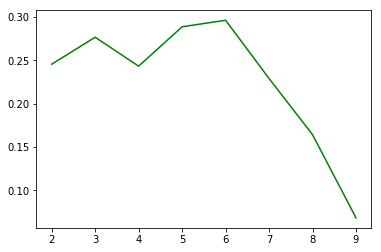

In [80]:
import matplotlib.pyplot as plt
from sklearn import metrics

Toronto_grouped_clustering = Toronto_grouped.drop(['Borough','Neighborhoods'], 1)

score_list = list()
Ks = 10
silhouette_int = -1
silhouette_tmp = np.zeros((Ks-2))
for n in range(2, Ks): 
    model_kmeans =KMeans(n_clusters=n, random_state=0) 
    cluster_labels_tmp =model_kmeans.fit_predict(Toronto_grouped_clustering)

    silhouette_tmp[n-2] =metrics.silhouette_score(Toronto_grouped_clustering, cluster_labels_tmp) 
    if silhouette_tmp[n-2] >silhouette_int:  
        best_k =n  
        silhouette_int =silhouette_tmp[n-2]  
        best_kmeans =model_kmeans  
        cluster_labels_k =cluster_labels_tmp  
print ('Best K is:{0} with average silhouette of{1}'.format(best_k, silhouette_int.round(4)))
plt.plot(range(2,Ks),silhouette_tmp,'g')
plt.show()

In [81]:
K = 6

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=K, n_init=10, random_state = 0).fit(Toronto_grouped_clustering)

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [82]:
Toronto_merged = df_ll

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.merge(neighborhoods_venues_sorted.set_index(['Borough','Neighborhoods']), how = 'right',left_on=['Borough','Neighbourhood'], right_on=['Borough','Neighborhoods'])

Toronto_merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,1,Fast Food Restaurant,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Hardware Store,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Dim Sum Restaurant,Yoga Studio,Department Store,Deli / Bodega,Dance Studio,Curling Ice,Cupcake Shop,Cuban Restaurant,Creperie
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,0,Bar,Yoga Studio,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Festival,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio,Curling Ice,Cupcake Shop,Cuban Restaurant
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,4,Intersection,Breakfast Spot,Pizza Place,Rental Car Location,Electronics Store,Medical Center,Mexican Restaurant,Donut Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Yoga Studio,Drugstore,Dim Sum Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Dumpling Restaurant,Dessert Shop,Falafel Restaurant,Department Store,Deli / Bodega,Dance Studio,Curling Ice
3,M1G,Scarborough,Woburn,43.770992,-79.216917,4,Coffee Shop,Korean Restaurant,Yoga Studio,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Dim Sum Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Diner,Dessert Shop,Festival,Department Store,Deli / Bodega,Dance Studio,Curling Ice,Cupcake Shop
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,4,Bakery,Hakka Restaurant,Bank,Caribbean Restaurant,Athletics & Sports,Fried Chicken Joint,Thai Restaurant,Donut Shop,Discount Store,Dog Run,Doner Restaurant,Yoga Studio,Diner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Drugstore,Dessert Shop,Dim Sum Restaurant,Fast Food Restaurant,Department Store


### Visualize the clusters

In [83]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(K)
ys = [i + x + (i*x)**2 for i in range(K)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighbourhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### If we only focus on the boroughs that contain the word Toronto, such as: Downtown Toronto, East Toronto, West Toronto, Central Toronto.

In [84]:
Focus_borough = df_ll[df_ll['Borough'].str.contains('Toronto')]
Focus_borough.reset_index(inplace=True,drop=True)
Focus_borough.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


Add our **Focused neighborhoods** superimposed on the previous Toronto map.

In [85]:
# add markers to map
for lat, lng, borough, neighbourhood in zip(Focus_borough['Latitude'], Focus_borough['Longitude'], Focus_borough['Borough'], Focus_borough['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

In [86]:
Focus_venues = getNearbyVenues(boroughs=Focus_borough['Borough'],
                               names=Focus_borough['Neighbourhood'],
                               latitudes=Focus_borough['Latitude'],
                               longitudes=Focus_borough['Longitude']
                              )

In [87]:
Focus_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,East Toronto,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,East Toronto,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,East Toronto,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,East Toronto,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


#### Analyze the focused neighborhood

In [88]:
Focus_onehot = pd.get_dummies(Focus_venues[['Venue Category']], prefix="", prefix_sep="")
fixed_columns = ['Borough','Neighborhoods']+list(Focus_onehot.columns)
# add neighborhood column back to dataframe
Focus_onehot['Neighborhoods'] = Focus_venues ['Neighborhood'] 
Focus_onehot['Borough'] = Focus_venues ['Borough'] 
Focus_onehot = Focus_onehot[fixed_columns]
Focus_onehot.head()

,Borough,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,East Toronto,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,East Toronto,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [89]:
Focus_grouped = Focus_onehot.groupby(['Borough','Neighborhoods']).mean().reset_index()
print(Focus_grouped.shape)
Focus_grouped.head()

(38, 235)


,Borough,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,Central Toronto,Davisville,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.030303,0.0,0.0,0.0,0.0,0.000000,0.0,0.060606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.060606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030303,0.0,0.0,0.0,0.0,0.0,0.030303,0.0,0.090909,0.0,0.030303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.030303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030303,0.030303,0.0,0.060606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.

### Clustering for the focused neighborhood

Determine the best K for Kmeans

Best K is:3 with average silhouette of0.6406


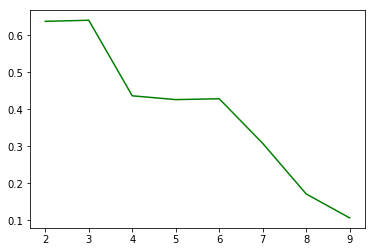

In [100]:
Focus_grouped_clustering = Focus_grouped.drop(['Borough','Neighborhoods'], 1)

score_list_f = list()
Kf = 10
silhouette_int_f = -1
silhouette_tmp_f = np.zeros((Ks-2))
for n in range(2, Kf): 
    model_kmeans =KMeans(n_clusters=n, random_state=0) 
    cluster_labels_tmp =model_kmeans.fit_predict(Focus_grouped_clustering)

    silhouette_tmp_f[n-2] =metrics.silhouette_score(Focus_grouped_clustering, cluster_labels_tmp) 
    if silhouette_tmp_f[n-2] >silhouette_int_f:  
        best_kf =n  
        silhouette_int_f =silhouette_tmp_f[n-2]  
        best_kmeans =model_kmeans  
        cluster_labels_k =cluster_labels_tmp  
print ('Best K is:{0} with average silhouette of{1}'.format(best_kf, silhouette_int_f.round(4)))
plt.plot(range(2,Kf),silhouette_tmp_f,'g')
plt.show()

In [95]:
K = 3

# run k-means clustering
kmeans_focus = KMeans(init="k-means++", n_clusters=K, n_init=10, random_state = 0).fit(Focus_grouped_clustering)

neighborhoods_venues_sorted_f = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_f['Neighborhoods'] = Focus_grouped['Neighborhoods']
neighborhoods_venues_sorted_f['Borough'] = Focus_grouped['Borough']


for ind in np.arange(Focus_grouped.shape[0]):
    neighborhoods_venues_sorted_f.iloc[ind, 2:] = return_most_common_venues(Focus_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_f.head()
neighborhoods_venues_sorted_f.insert(0, 'Cluster Labels', kmeans_focus.labels_)

In [96]:
Focus_merged = Focus_borough

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Focus_merged = Focus_merged.merge(neighborhoods_venues_sorted_f.set_index(['Borough','Neighborhoods']), how = 'right',left_on=['Borough','Neighbourhood'], right_on=['Borough','Neighborhoods'])

Focus_merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Neighborhood,Trail,Pub,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Festival,Dessert Shop,Department Store,Deli / Bodega,Dance Studio,Cupcake Shop,Cuban Restaurant,Creperie
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Bookstore,Ice Cream Shop,Yoga Studio,Brewery,Bubble Tea Shop,Café,Restaurant,Caribbean Restaurant,Pub,Cosmetics Shop,Pizza Place,Sports Bar,Dessert Shop,Diner,Liquor Store,Juice Bar,Indian Restaurant,Fruit & Vegetable Store,Spa,Grocery Store,Bakery
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,0,Park,Sandwich Place,Sushi Restaurant,Pet Store,Pizza Place,Pub,Movie Theater,Burrito Place,Burger Joint,Brewery,Fast Food Restaurant,Fish & Chips Shop,Steakhouse,Food & Drink Shop,Italian Restaurant,Gym,Liquor Store,Ice Cream Shop,Deli / Bodega,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Park,Seafood Restaurant,Sandwich Place,Cheese Shop,Chinese Restaurant,Clothing Store,Convenience Store,Neighborhood,Coworking Space,Bookstore,Diner,Middle Eastern Restaurant,Latin American Restaurant,Fish Market,Ice Cream Shop,Gastropub,Gay Bar,Gym / Fitness Center,Brewery
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Park,Bus Line,Swim School,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Discount Store,Filipino Restaurant,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio,Cupcake Shop,Cuban Restaurant


In [98]:
map_clusters_focus = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(K)
ys = [i + x + (i*x)**2 for i in range(K)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Focus_merged['Latitude'], Focus_merged['Longitude'], Focus_merged['Neighbourhood'], Focus_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_focus)
       
map_clusters_focus

### Conclusion:
+ If we look at all the boroughs of Toronto, there are clearly 6 clustering based on data of venues' categories.
+ When we only look at the boroughs of Downtown Toronto, East Toronto, West Toronto, Central Toronto, almost all the neighborhoods are in the same clustering regarding the data of venues.